# DSCI100 Final Project Report: Predicting Subscription of Newsletter for a Video Game Research Server

Names: Christopher Lee, Seungmin Lee

## 1) Introduction

The research group led by UBC computer science professor Frank Wood set up a Minecraft server to collect data to learn more about people's video game behaviours. Demographics such as age, gender, and experience as well as the number of hours played on the server were tracked. A major challenge in running this project is ensuring how the team should target recruitment efforts. Therefore, this data analysis was done as an exploration in part with Dr. Wood's team. Our analysis will focus on one of the major issues related to targeting recruitment efforts, which is focusing on certain behaviours or characteristics in predicting subscription to a newsletter. 

In this project, we aimed to respond to this issue by exploring the question: 

**"Can age, experience, and player hours predict whether or not a player will subscribe to the newsletter?"**

We attempted to answer this question by employing a predictive K-NN classfication model. Data from the "players.csv" dataset was used as it included the relevant predictor and response variables. This dataset includes 196 observations and 7 variables.

Variable information for the "players.csv" dataset:
1. `experience` (**character**):
    - player's experience playing Minecraft
2. `subscribe` (**logical**):
    - player's subscription status
3. `hashedEmail` (**character**):
    - player's hashed email
4. `played_hours` (**numeric (double)**):
    - player's total played hours on the server
5. `name` (**character**):
    - player's name
6. `gender` (**character**):
    - player's gender
7. `Age` (**numeric (double)**):
    - player's age

The dataset may include potential issues, such as NA values for some players' ages.

## 2) Methods & Results

To ensure reproducibility in our project, we will first set the seed since tools we will be using involve randomness.

In [1]:
set.seed(1234)
library(tidyverse)
library(repr)
library(tidymodels)
library(ggplot2)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

Next, we will load in the "players.csv" dataset. We will clean the data by selecting only the variables of interest: experience, played_hours, age, and subscribe.

Additionally, we will turn the predictor variable experience to a numeric, and response variable subscribe to a factor so it can be consistent with a typical KNN classification.

Based on level progression, we will assign:
- Beginner --> 1
- Amateur --> 2
- Regular --> 3
- Pro --> 4
- Veteran --> 5

Finally, we will remove any NA values to prevent issues later on.

In [2]:
# load data
player_data_url <- "https://raw.githubusercontent.com/chrislee330/dsci-100-project/refs/heads/main/data/players.csv"
players <- read_csv(player_data_url)
players <- players |> select(experience, Age, subscribe, played_hours) |>
                        mutate(subscribe = as.factor(subscribe)) |>
                        mutate(experience = recode(experience, "Beginner" = 1, "Amateur" = 2, "Regular" = 3, "Pro" = 4, "Veteran" = 5)) |>
                        filter(Age != "NA")
head(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,Age,subscribe,played_hours
<dbl>,<dbl>,<fct>,<dbl>
4,9,TRUE,30.3
5,17,TRUE,3.8
5,17,FALSE,0.0
2,21,TRUE,0.7
3,21,TRUE,0.1
2,17,TRUE,0.0


We will first split the data into training and testing sets to prevent overfitting and ensuring that our model generalizes well on unseen data. We will only perform exploratory analysis and prediction only on the training set. We have decided to use 75% of the data in the training set and use the response varaible subscribe as the strata.

In [3]:
players_split = initial_split(players, prop = 0.75, strata = subscribe)
players_train <- training(players_split)
players_test <- testing(players_split)

Summary statistics of the training set:

In [4]:
summary(players_train)

   experience       Age       subscribe    played_hours    
 Min.   :1.0   Min.   :10.0   FALSE: 39   Min.   :  0.000  
 1st Qu.:2.0   1st Qu.:17.0   TRUE :106   1st Qu.:  0.000  
 Median :2.0   Median :19.0               Median :  0.100  
 Mean   :2.8   Mean   :20.9               Mean   :  6.143  
 3rd Qu.:4.0   3rd Qu.:22.0               3rd Qu.:  0.600  
 Max.   :5.0   Max.   :57.0               Max.   :223.100  

We will create exploratory scatterplot visualizations of the training set. These include the following:
- Relationship between Experience, Age, and Subscription Status of Players
- Relationship between Age, Played hours, and Subscription Status of Players
- Relationship between Played hours, Experience, and Subscription Status of Players

We will put the predictor variables on the axes and use color to show subscription class. Since experience has discrete values, there will be five distinct layers.

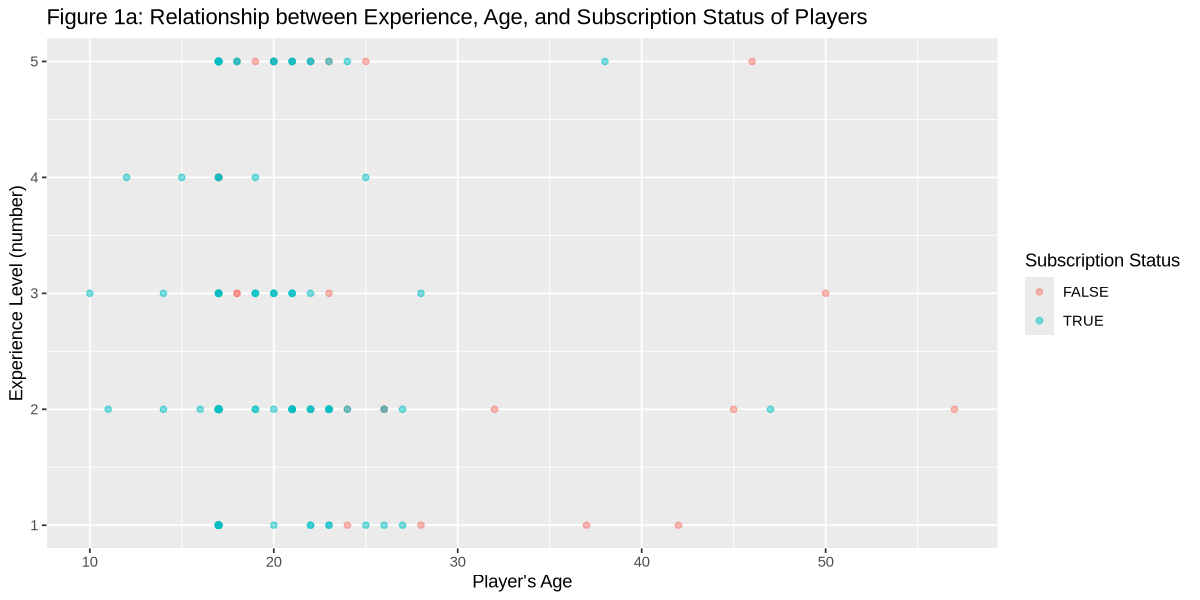

In [5]:
options(repr.plot.width = 10, repr.plot.height = 5)
training_plot_1 <- players_train |>
                    ggplot(aes(x = Age, y = experience, color = subscribe)) +
                        geom_point(alpha = 0.5) +
                        labs(x = "Player's Age", y = "Experience Level (number)", color = "Subscription Status") +
                        ggtitle("Figure 1a: Relationship between Experience, Age, and Subscription Status of Players")
training_plot_1

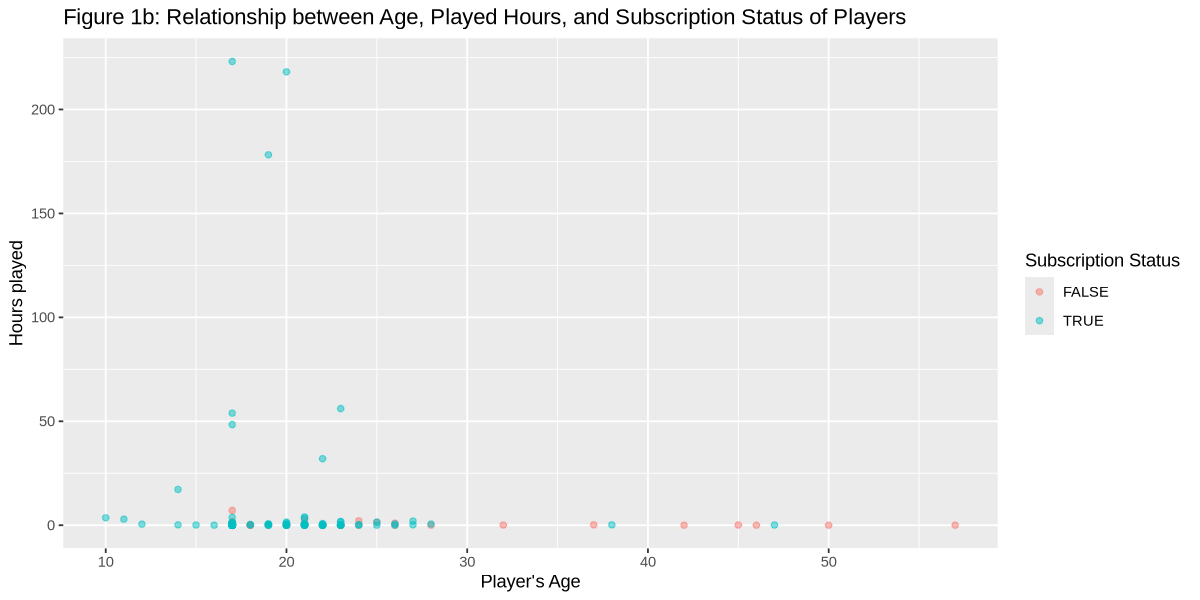

In [6]:
training_plot_2 <- players_train |>
                    ggplot(aes(x = Age, y = played_hours, color = subscribe)) +
                        geom_point(alpha = 0.5) +
                        labs(x = "Player's Age", y = "Hours played", color = "Subscription Status") +
                        ggtitle("Figure 1b: Relationship between Age, Played Hours, and Subscription Status of Players")
training_plot_2

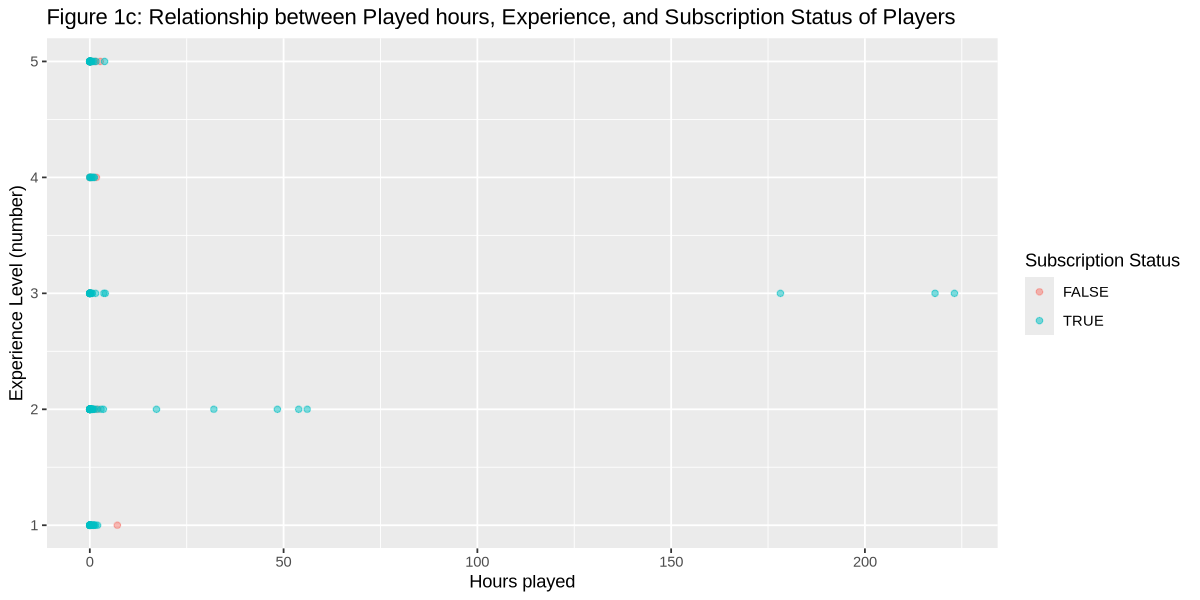

In [7]:
training_plot_3 <- players_train |>
                    ggplot(aes(x = played_hours, y = experience, color = subscribe)) +
                        geom_point(alpha = 0.5) +
                        labs(x = "Hours played", y = "Experience Level (number)", color = "Subscription Status") +
                        ggtitle("Figure 1c: Relationship between Played hours, Experience, and Subscription Status of Players")
training_plot_3

From the visualizations, there does not seem to be distinct relationships in the data. However, we can see that the demographic is mainly centered around people aged 20. Furthermore, there appears to be groups with clear class distinctions. Players with lower experience levels aged 30 to 40 seem to not subscribe, while players of higher experience levels around ages 15-25 seem to subscribe.

Although the experience is a bit distributed among players, there seems to be a disproportion of data centered around ages 16 to 25. Therefore, we will investigate by creating a histogram that compares age and subscription status.

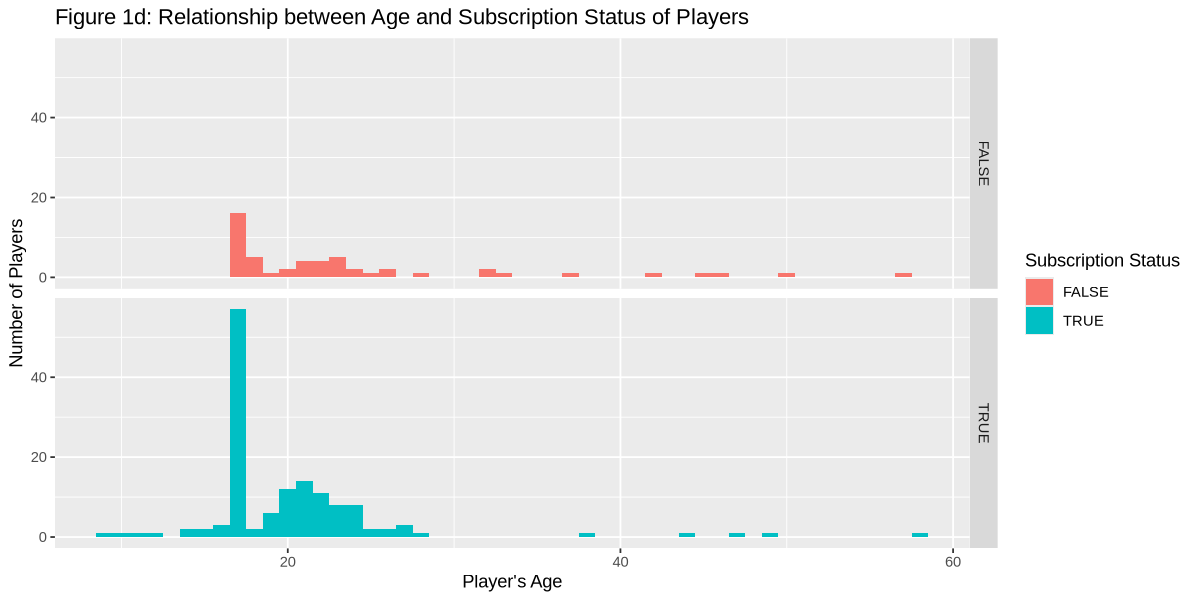

In [8]:
training_plot_4 <- players |>
                  ggplot(aes(x = Age, fill = subscribe)) +
                    geom_histogram(binwidth = 1) +
                    facet_grid(rows = vars(subscribe)) +
                    labs(x = "Player's Age", y = "Number of Players", fill = "Subscription Status") +
                    ggtitle("Figure 1d: Relationship between Age and Subscription Status of Players")
training_plot_4

From the visualization (Figure 1d), we see that there is indeed a lot of data around the ages of late teens to early 20s. 
We see that indeed, there is a lot of data centred around the ages of late teens to early 20s. Despite this being a possible concern for the quality of the predictive model, we will keep this in mind when evaluating its performance.

### Data Analysis

The data analysis will consist of setting up and evaluating a KNN classification model with three quantitative variables as predictors and a factor as a response variable. This method is appropriate because I want to predict a class based on three quantitative variables and K-NN method fits these parameters.
We will choose an optimal k-value by tuning the model. Finally with this k-value, we will test the revised model against the testing data to evaluate its accuracy and metrics.
Specifically:
1) create recipe and model specification for training data
    - tuning specification by setting neighbour = tune()
    - standardize data so all predictors have equal contributions
2) create a 5-fold cross validation to test values of k from 1 to 20 to choose the optimal value of k
3) create a workflow to combine the recipe, tuning specification, and information of cross-validation.
    - collect the accuracy of this workflow and show its results as a visualization and tibble

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
12,accuracy,binary,0.7661248,5,0.01827682,Preprocessor1_Model12
11,accuracy,binary,0.7592282,5,0.01698749,Preprocessor1_Model11
13,accuracy,binary,0.7589819,5,0.01369486,Preprocessor1_Model13
14,accuracy,binary,0.7589819,5,0.01369486,Preprocessor1_Model14
15,accuracy,binary,0.7520854,5,0.01083749,Preprocessor1_Model15
17,accuracy,binary,0.7520854,5,0.01537391,Preprocessor1_Model17


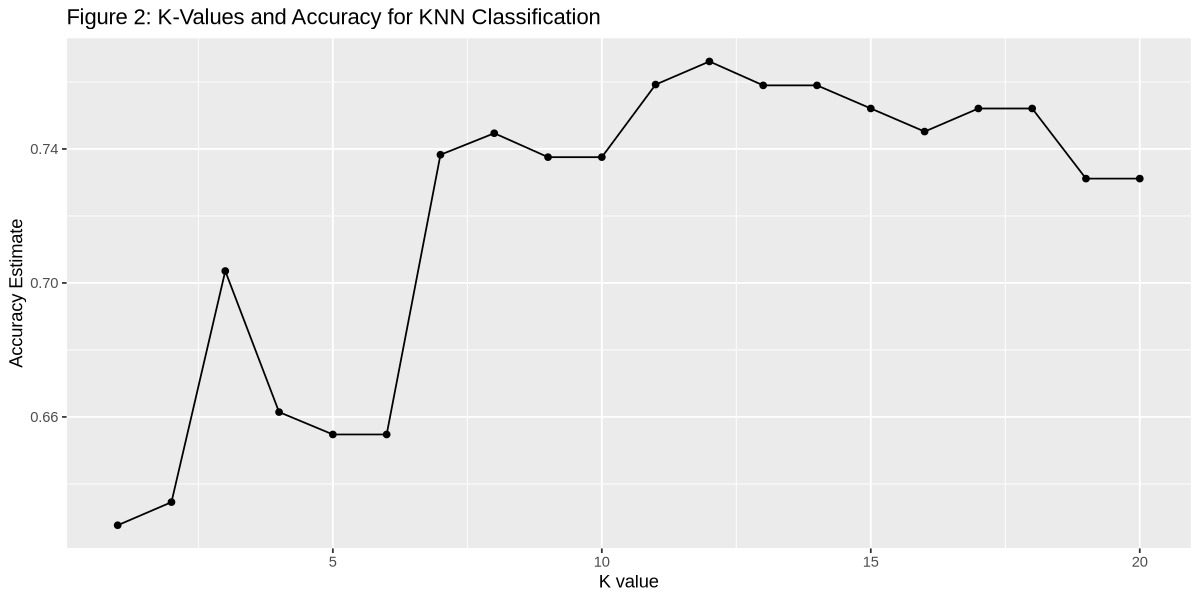

In [9]:
set.seed(1234)
players_recipe <- recipe(subscribe ~ ., data = players_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
tune_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")
players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)
k_vals <- tibble(neighbors = seq(1, 20, by = 1))

tune_workflow <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(tune_spec) |>
    tune_grid(resamples = players_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")

cv_results <- tune_workflow |> arrange(desc(mean))
cv_plot <- ggplot(tune_workflow, aes(x = neighbors, y = mean)) +
                        geom_point() +
                        geom_line() +
                        labs(x = "K value", y = "Accuracy Estimate") + 
                        ggtitle("Figure 2: K-Values and Accuracy for KNN Classification")
head(cv_results)
cv_plot

Based off the tibble and k-value and accuracy visualization, the optimal k-value is 12 because it has the highest accuracy. Next, we will use 12 neighbors to recreate the model specification, workflow, and finally fit the training data on it.

In [10]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 12) |>
    set_engine("kknn") |>
    set_mode("classification")

players_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_spec) |>
    fit(data = players_train)
players_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(12,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2482759
Best kernel: rectangular
Best k: 12

Next, we can use the model to make predictions on the testing data so that we can evaluate its metrics and filtering for accuracy.
Our model is now ready to evaluate against the testing data. We will use the model to make predictions on the testing data and compare them to the true classes of the testing observations, evaluating metrics and filtering for accuracy.

In [11]:
players_predictions <- predict(players_fit, players_test) |>
    bind_cols(players_test)
players_accuracy <- players_predictions |> 
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")
players_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6938776


Our model was about 69% accurate at predicting the subscription class. This accuracy is not the worst, but it is also not the best. 

<!-- ADD create new obs based?
To further evaluate the model, we will have the model predict the class based on new observations generated from the testing data points. These observations will be created by analyzing different values from a visualization made from the testing data. We avoid using training data to avoid allowing the model to simply reflect patterns it has already seen before. -->

Next, we will examine the confusion matrix to determine if the model has a tendency to predict TRUE, even in cases where it should predict FALSE.

In [12]:
prediction_matrix <- players_predictions |>
                        conf_mat(truth = subscribe, estimate = .pred_class)
prediction_matrix 

          Truth
Prediction FALSE TRUE
     FALSE     1    3
     TRUE     12   33

From the confusion matrix, it shows that there are a large number of false positives (when model predicted TRUE when should have been FALSE). We can conclude that our model has lower accuracy and precision, but high recall. The implications is furthered elaborated on in the Discussion section.

## 3) Discussion

**Summary of Findings** \
From our visualizations (Figure 1a, 1b, 1c),  we saw that subscribers and non-subscribers look very mixed together. Age, experience level, and hours played did not clearly separate the two groups. Players with different subscription statuses appeared in similar areas of the plots, so there was no strong pattern. The age histogram from Figure 1d also showed that most players are between 16 and 25 years old, which means the data is not very balanced. After tuning the K-NN model, the best value of k = 12 from Figure 2 gave us the highest accuracy during cross-validation. When we tested the model, the accuracy was around 69%. While it was not as accurate as we hoped, these findings may still have an important impact in targeting subscription. The confusion matrix showed that the model made many false positives. It overly predicted TRUE even when the actual answer was FALSE. This means the model has low precision but higher recall.

**Implications**\
A model having low precision indicates that out of all the users the model predicted to subscribe to the newsletter, only some of them actually did. However, a model having high recall means that out of all the users that did actually subscribe, the model predicted that most of them would. In this case (subscription status for newsletter), high recall may have benefits since the model can predict whether certain individuals will subscribe. These individuals are the main targets for the research team and it would not have much negative effects if it predicted that someone will subscribe when they actually would not. It would be much worse to predict here that someone will not subscribe when they actually will. Therefore, it would be better to target players who might not subscribe rather than missing the opportunity to get an interested individual to subscribe. In other words, it would be a waste of time and resources to reach out to players that would subscribe.

**Is This What We Expected?** \
Yes, these results are mostly what we expected. From the scatterplots, we already saw that the data did not show strong differences between subscribers and non-subscribers. Because of this, it made sense that the K-NN model would only reach a moderate accuracy like 69%. The age distribution is also very unbalanced, with most players being young. This makes it harder for the model to learn patterns, so it was not surprising that the model sometimes predicts TRUE too often.

**Impact of These Findings**  
* Age, experience, and hours played do not strongly predict whether someone subscribes to the newsletter
* A high number of false positives means the model might overestimate interest, which could lead to wasted recruitment or communication efforts
* Because the data mainly comes from younger players, the model may not work well for the general population of Minecraft users
* To better understand subscription behavior, the team might need more detailed or different kinds of variables, such as login frequency, how social the player is, or how often they interact with the server.

**Future Question**
1. Are there better predictors that would help us understand subscription behavior? (Ex: gender)
2. Would another model work better than K-NN? (Ex: logistic regression)
3. Can we group players into clusters to find different types of players with different subscription habits?